## Learning embeddings with LTN

A classic example of Statistical Relational Learning is the smokers-friends-cancer example introduced in the paper
about Markov Logic Networks. Below, we show how this example can be formalized in LTN using semi-supervised
embedding learning.

The problem is the following. There are 14 people divided into two groups $\{a, b, \dots, h\}$ and $\{i, j, \dots, n\}$.
Within each group, there is complete knowledge about smoking habits. In the first group, there is complete knowledge
about who has and who does not have cancer. Knowledge about the friendship relation is complete within each group only
if symmetry is assumed, that is, $\forall x,y \text{ } (friends(x,y) \implies friends(y,x))$. Otherwise, knowledge about
friendship is incomplete in that it may be known that e.g. $a$ is a friend of $b$, and it may be not known whether
$b$ is a friend of $a$. Finally, there is general knowledge about smoking, friendship and cancer, namely that smoking
causes cancer, friendship is normally symmetric and anti-reflexive, everyone has a friend, and smoking propagates
(actively or passively) among friends. All this knowledge is represented in the axioms further below.

For this specific task, LTN uses the following language and grounding:

**Domains:**
- $people$, denoting the individuals of the smokers-friends-cancer dataset.

**Variables:**
- $x, y$ ranging over the individuals;
- $D(x) = D(y) = people$.

**Constants:**
- $a, b, \dots, h, i, j, \dots, n$, the 14 individuals. Our goal is to learn an adequate embedding for each constant;
- $D(a) = D(b) = \dots = D(n) = people$.

**Predicates:**
- $S(x)$ for *smokes*, $F(x,y)$ for *friends*, $C(x)$ for *cancer*;
- $D_{in}(S) = D_{in}(C) = people$;
- $D_{in}(F) = people,people$.

**Axioms:**

Let $\mathcal{X}_1 = \{a, b, \dots, h\}$ and $\mathcal{X}_2 = \{i, j, \dots, n\}$ be the two set of individuals.

Let $\mathcal{S} = \{a, e, f, g, j, n\}$ be the set of the smokers. Knowledge is complete in both groups.

Let $\mathcal{C} = \{a, e\}$ be the set of individuals with cancer. Knowledge is complete on $\mathcal{X}_1$ only.

Let $\mathcal{F} = \{(a,b), (a,e), (a, f), (a, g), (b, c), (c, d), (e, f), (g, h), (i, j), (j, m), (k, l), (m, n)\}$ be the
set of friendship relations. Knowledge is complete if assuming symmetry.

These facts are illustrated in the following figure.

![Facts](./images/facts.png)

We have the following axioms:
- $F(u,v)$ for $(u, v) \in \mathcal{F}$;
- $\lnot F(u, v)$ for $(u, v) \notin \mathcal{F}, u > v$;
- $S(u)$ for $u \in \mathcal{S}$;
- $\lnot S(u)$ for $u \in (\mathcal{X}_1 \cup \mathcal{X}_2) \backslash \mathcal{S}$;
- $C(u)$ for $u \in \mathcal{C}$;
- $\lnot C(u)$ for $u \in \mathcal{X}_1 \backslash \mathcal{C}$;
- $\forall x \text{ } \lnot F(x,x)$;
- $\forall x, y \text{ } (F(x, y) \implies F(y,x))$;
- $\forall x \exists y \text{ } F(x,y)$;
- $\forall x, y \text{ } ((F(x, y) \land S(x)) \implies S(y))$;
- $\forall x \text{ } (S(x) \implies C(x))$;
- $\forall x \text{ } (\lnot C(x) \implies \lnot S(x))$.

Notice that the knowledge base is not satisfiable in the strict logical sense of the word. For instance, $f$ is said to
smoke but not to have cancer, which is inconsistent with the rule $\forall x \text{ } (S(x) \implies C(x))$. Hence, it
is important to adopt a probabilistic approach as done with MLN or a many-valued fuzzy logic interpretation as done
with LTN. This allows to relax the constraints, leading to soft constraints. With soft constraints, it is possible to find
a solution which maximally satisfy all the constraints and better generalizes real world data compared to hard constrains.

**Grounding:**
- $\mathcal{G}(people)=\mathbb{R}^{5}$. The model is expected to learn embeddings in $\mathbb{R}^{5}$;
- $\mathcal{G}(a \mid \theta)=\mathbf{v}_\theta(a), \dots \mathcal{G}(n \mid \theta)=\mathbf{v}_\theta(n)$, where with
$\mathbf{v}_\theta(x)$ we denote the vector containing the parameters of individual $x$, namely the embedding of $x$.
Every individual is associated with a vector of 5 real numbers. The embedding is initialized randomly and uniformly;
- $\mathcal{G}(x \mid \theta)=\mathcal{G}(y \mid \theta) = \langle \mathbf{v}_\theta(a), \dots, \mathbf{v}_\theta(n) \rangle$, namely variables
$x$ and $y$ are sequences of embeddings of the individuals in the dataset;
- $\mathcal{G}(S \mid \theta) : x \mapsto \sigma(\operatorname{MLP\_S}_\theta(x))$, where $\operatorname{MLP\_S}_\theta$
has 1 output neuron. In other words, $S$ returns the probability that $x$ is a smoker, given its features (embedding) in
input;
- $\mathcal{G}(F \mid \theta) : x,y \mapsto \sigma(\operatorname{MLP\_F}_\theta(x,y))$, where $\operatorname{MLP\_F}_\theta$
has 1 output neuron. In other words, $F$ returns the probability that $x$ and $y$ are friends, given their features (embeddings) in
input;
- $\mathcal{G}(C \mid \theta) : x \mapsto \sigma(\operatorname{MLP\_C}_\theta(x))$, where $\operatorname{MLP\_C}_\theta$
has 1 output neuron. In other words, $C$ returns the probability that $x$ has cancer, given its features (embedding) in
input.

The *MLP* models for $S$, $F$, and $C$ are kept simple, so that most of the learning is focused on the embeddings.

### Dataset

Now, let's create our dataset, according to the specification defined above.

In order to define the dataset, it is enough to create an embedding in $\mathbb{R}^5$ for each individual. The individuals
will be represented in LTN by learnable constants containing the embeddings of the individuals.

Then, we have to define our knowledge, namely the two groups of people, who has cancer, who is a smoker, and the set of
friendship relations.

In [6]:
import ltn
import torch

embedding_size = 5

# first group of people
g1 = {person: ltn.Constant(torch.rand((embedding_size,)), trainable=True) for person in 'abcdefgh'}
# second group of people
g2 = {person: ltn.Constant(torch.rand((embedding_size,)), trainable=True) for person in 'ijklmn'}
# group of all people
g = {**g1, **g2}

# we define friendship relations, who has cancer and who is a smoker
friends = [('a', 'b'), ('a', 'e'), ('a', 'f'), ('a', 'g'), ('b', 'c'), ('c', 'd'), ('e', 'f'), ('g', 'h'),
               ('i', 'j'), ('j', 'm'), ('k', 'l'), ('m', 'n')]
smokes = ['a', 'e', 'f', 'g', 'j', 'n']
cancer = ['a', 'e']

### LTN setting

In order to define our knowledge base (axioms), we need to define predicates $F,C,S$,
connectives, quantifiers, and the `SatAgg` operator.

For the connectives and quantifiers, we use the stable product configuration (seen in the tutorials).

For predicates $F,C,S$, we use simple $MLP$ models with two hidden layers each.

`SatAgg` is defined using the `pMeanError` aggregator.

In [7]:
# we define predicates F, C, and S
class MLP(torch.nn.Module):
    """
    Simple MLP model used for defining the predicates of our problem.
    """
    def __init__(self, layer_sizes=(10, 16, 16, 1)):
        super(MLP, self).__init__()
        self.elu = torch.nn.ELU()
        self.sigmoid = torch.nn.Sigmoid()
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(layer_sizes[i - 1], layer_sizes[i])
                                                  for i in range(1, len(layer_sizes))])

    def forward(self, *x):
        """
        Given an individual x, the forward phase of this MLP returns the probability that the individual x is a smoker,
        or has cancer, or is friend of y (if given and predicate is F).

        :param x: individuals for which we have to compute the probability
        :return: the probability that individual x is a smoker, or has cancer, or is friend of y (if given)
        """
        x = list(x)
        if len(x) == 1:
            x = x[0]
        else:
            x = torch.cat(x, dim=1)
        for layer in self.linear_layers[:-1]:
            x = self.elu(layer(x))
        out = self.sigmoid(self.linear_layers[-1](x))
        return out

C = ltn.Predicate(MLP(layer_sizes=(5, 16, 16, 1)))
S = ltn.Predicate(MLP(layer_sizes=(5, 16, 16, 1)))
F = ltn.Predicate(MLP(layer_sizes=(10, 16, 16, 1)))

# we define connectives, quantifiers, and SatAgg
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
SatAgg = ltn.fuzzy_ops.SatAgg()

### Learning

Let us define $D$ the data set of all examples. The objective function with $\mathcal{K}$
is given by $\operatorname{SatAgg}_{\phi \in \mathcal{K}} \mathcal{G}_{\boldsymbol{\theta}, x \leftarrow \boldsymbol{D}}(\phi)$.

In practice, the optimizer uses the following loss function:

$\boldsymbol{L}=\left(1-\underset{\phi \in \mathcal{K}}{\operatorname{SatAgg}} \mathcal{G}_{\boldsymbol{\theta}, x \leftarrow \boldsymbol{B}}(\phi)\right)$

where $B$ is a mini batch sampled from $D$.

In the following, we learn our LTN in the embedding learning task using the satisfaction of the knowledge base as
an objective. In other words, we want to learn the parameters $\theta$ (embeddings + MLPs of predicates) in such a way the
axioms in the knowledge base are maximally satisfied.

We train our model for 1000 epochs and use the `Adam` optimizer. In particular, for $\forall$, we use
`pMeanError` with $p=2$ for all the rules, except for rules in $\{\forall x \text{ } \lnot F(x,x), \forall x,y \text{ } (F(x,y) \implies F(y,x)) \}$, for which we use $p=6$.
The intuition behind this choice of $p$ is that no outliers are to be accepted for the friendship relation since it is
expected to be symmetric and anti-reflexive, instead, outliers are accepted for the other rules.

For $\exists$, we use `pMean` with $p=1$ during the first 200 epochs of training, and $p=6$ thereafter, with the same motivation
as that of the schedule used in the previous examples.

### Querying

During training, to illustrate querying in LTN, we query over time two formulas which are not present in the knowledge base:
- $\phi_1 : \forall p \text { } C(p) \implies S(p)$: states that who has cancer is also a smoker;
- $\phi_2 : \forall p,q \text{ } (C(p) \lor C(q)) \implies F(p,q)$: states that if at least one of two individuals in a pair
have cancer then they are also friends.

We use $p=5$ when approximating $\forall$ since the impact of an outlier at querying time should be seen as more
important than at learning time.

In the following, we define also the two functions which compute $\phi_1$ and $\phi_2$ during training.

In [8]:
# functions which compute phi1 and phi2
# we need disjunction connective for phi2
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
# this function returns the satisfaction level of the logical formula phi 1
def phi1():
    p = ltn.Variable("p", torch.stack([i.value for i in g.values()]))
    return Forall(p, Implies(C(p), S(p)), p=5).value

# this function returns the satisfaction level of the logical formula phi2
def phi2():
    p = ltn.Variable("p", torch.stack([i.value for i in g.values()]))
    q = ltn.Variable("q", torch.stack([i.value for i in g.values()]))
    return Forall([p, q], Implies(Or(C(p), C(q)), F(p, q)), p=5).value

# we have to optimize the parameters of the three predicates and also of the embeddings
params = list(S.parameters()) + list(F.parameters()) + list(C.parameters()) + [i.value for i in g.values()]
optimizer = torch.optim.Adam(params, lr=0.001)

for epoch in range(1000):
    if epoch <= 200:
        p_exists = 1
    else:
        p_exists = 6
    optimizer.zero_grad()

    # ground the variables
    """
    NOTE: we update the embeddings at each step
        -> we should re-compute the variables.
    """
    x_ = ltn.Variable("x", torch.stack([i.value for i in g.values()]))
    y_ = ltn.Variable("y", torch.stack([i.value for i in g.values()]))

    sat_agg = SatAgg(
        # Friends: knowledge incomplete in that
        #     Friend(x,y) with x<y may be known
        #     but Friend(y,x) may not be known
        SatAgg(*[F(g[x], g[y]) for (x, y) in friends]),
        SatAgg(*[Not(F(g[x], g[y])) for x in g1 for y in g1 if (x, y) not in friends and x < y] +
                [Not(F(g[x], g[y])) for x in g2 for y in g2 if (x, y) not in friends and x < y]),

        # Smokes: knowledge complete
        SatAgg(*[S(g[x]) for x in smokes]),
        SatAgg(*[Not(S(g[x])) for x in g if x not in smokes]),

        # Cancer: knowledge complete in g1 only
        SatAgg(*[C(g[x]) for x in cancer]),
        SatAgg(*[Not(C(g[x])) for x in g1 if x not in cancer]),

        # friendship is anti-reflexive (note that p=5)
        Forall(x_, Not(F(x_, x_)), p=5),

        # friendship is symmetric (note that p=5)
        Forall([x_, y_], Implies(F(x_, y_), F(y_, x_)), p=5),

        # everyone has a friend
        Forall(x_, Exists(y_, F(x_, y_), p=p_exists)),

        # smoking propagates among friends
        Forall([x_, y_], Implies(And(F(x_, y_), S(x_)), S(y_))),

        # smoking causes cancer + not smoking causes not cancer
        Forall(x_, Implies(S(x_), C(x_))),
        Forall(x_, Implies(Not(S(x_)), Not(C(x_))))
    )
    loss = 1. - sat_agg
    loss.backward()
    optimizer.step()

    # we print metrics every 20 epochs of training
    if epoch % 20 == 0:
        print(" epoch %d | loss %.4f | Train Sat %.3f | Phi1 Sat %.3f | Phi2 Sat %.3f" % (epoch, loss,
                    sat_agg, phi1(), phi2()))

 epoch 0 | loss 0.4282 | Train Sat 0.572 | Phi1 Sat 0.731 | Phi2 Sat 0.605
 epoch 20 | loss 0.4241 | Train Sat 0.576 | Phi1 Sat 0.748 | Phi2 Sat 0.605
 epoch 40 | loss 0.4173 | Train Sat 0.583 | Phi1 Sat 0.747 | Phi2 Sat 0.603
 epoch 60 | loss 0.4041 | Train Sat 0.596 | Phi1 Sat 0.748 | Phi2 Sat 0.604
 epoch 80 | loss 0.3814 | Train Sat 0.619 | Phi1 Sat 0.764 | Phi2 Sat 0.613
 epoch 100 | loss 0.3530 | Train Sat 0.647 | Phi1 Sat 0.801 | Phi2 Sat 0.609
 epoch 120 | loss 0.3288 | Train Sat 0.671 | Phi1 Sat 0.836 | Phi2 Sat 0.591
 epoch 140 | loss 0.3134 | Train Sat 0.687 | Phi1 Sat 0.881 | Phi2 Sat 0.570
 epoch 160 | loss 0.3047 | Train Sat 0.695 | Phi1 Sat 0.910 | Phi2 Sat 0.552
 epoch 180 | loss 0.2979 | Train Sat 0.702 | Phi1 Sat 0.926 | Phi2 Sat 0.538
 epoch 200 | loss 0.2921 | Train Sat 0.708 | Phi1 Sat 0.936 | Phi2 Sat 0.527
 epoch 220 | loss 0.2670 | Train Sat 0.733 | Phi1 Sat 0.941 | Phi2 Sat 0.422
 epoch 240 | loss 0.2590 | Train Sat 0.741 | Phi1 Sat 0.944 | Phi2 Sat 0.390
 epoc

Notice that in this example we do not have a data loader like in previous examples. In fact, variables $x$ and $y$ are
grounded with all the individuals at the beginning of each training step (epoch in this case).
In particular, it is necessary to ground the variables at each training step because the constants inside the variables
are constantly changing due to embedding learning step by step. Grounding the variables allows to PyTorch to recreate
the computational graph and perform gradient tracking correctly among epochs.

Notice also the use of `SatAgg` multiple times during one epoch of training. `SatAgg` is just a formula aggregator and
can be used every time we need to aggregate the results of some formulas. For example, the first formula in our knowledge
base is $F(u,v)$ for $(u, v) \in \mathcal{F}$. This formula is a set of formulas. `SatAgg` is used to compute the final
result, obtained aggregating the results of all the formulas in the set.

### Discussion on results

The following plot shows the facts (axioms for $S(x)$, $C(x)$, and $F(x,y)$) in the knowledge base before the training of LTN.

Yellow means that the value of the axiom is 1 (true), while violet means that the value of the axiom is 0 (false).

It is possible to observe that there are a lot of missing facts (depicted in white).

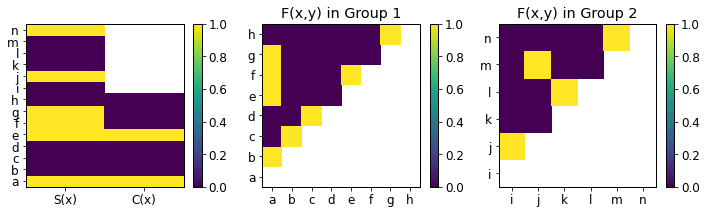

In [9]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

pd.options.display.max_rows=999
pd.options.display.max_columns=999
pd.set_option('display.width',1000)
pd.options.display.float_format = '{:,.2f}'.format

def plt_heatmap(df, vmin=None, vmax=None):
    plt.pcolor(df, vmin=vmin, vmax=vmax)
    plt.yticks(np.arange(0.5,len(df.index),1),df.index)
    plt.xticks(np.arange(0.5,len(df.columns),1),df.columns)
    plt.colorbar()

pd.set_option('precision',2)

df_smokes_cancer_facts = pd.DataFrame(
        np.array([[(x in smokes), (x in cancer) if x in g1 else math.nan] for x in g]),
        columns=["S(x)","C(x)"],
        index=list('abcdefghijklmn'))
df_friends_ah_facts = pd.DataFrame(
        np.array([[((x,y) in friends) if x<y else math.nan for x in g1] for y in g1]),
        index = list('abcdefgh'),
        columns = list('abcdefgh'))
df_friends_in_facts = pd.DataFrame(
        np.array([[((x,y) in friends) if x<y else math.nan for x in g2] for y in g2]),
        index = list('ijklmn'),
        columns = list('ijklmn'))

p = ltn.Variable("p", torch.stack([i.value for i in g.values()]))
q = ltn.Variable("q", torch.stack([i.value for i in g.values()]))

df_smokes_cancer = pd.DataFrame(
        torch.stack([S(p).value, C(p).value], dim=1).detach().numpy(),
        columns=["S(x)","C(x)"],
        index=list('abcdefghijklmn'))

pred_friends = F(p, q).value
df_friends_ah = pd.DataFrame(
        pred_friends[:8,:8].detach().numpy(),
        index=list('abcdefgh'),
        columns=list('abcdefgh'))
df_friends_in = pd.DataFrame(
        pred_friends[8:,8:].detach().numpy(),
        index=list('ijklmn'),
        columns=list('ijklmn'))
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1

plt.figure(figsize=(12,3))
plt.subplot(131)
plt_heatmap(df_smokes_cancer_facts, vmin=0, vmax=1)
plt.subplot(132)
plt.title("F(x,y) in Group 1")
plt_heatmap(df_friends_ah_facts, vmin=0, vmax=1)
plt.subplot(133)
plt.title("F(x,y) in Group 2")
plt_heatmap(df_friends_in_facts, vmin=0, vmax=1)
#plt.savefig('ex_smokes_givenfacts.pdf')
plt.show()

Now, we plot the truth values for $S(x), C(x), F(x,y)$, obtained by querying the predicates on all individuals by using
LTN after it has been trained for 1000 epochs.

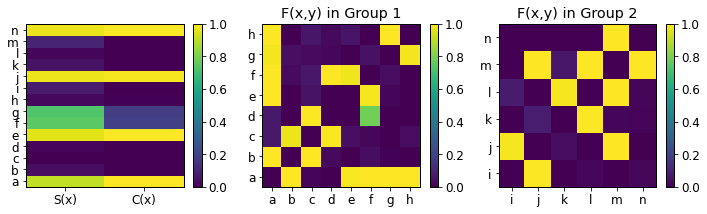

In [10]:
plt.figure(figsize=(12,3))
plt.subplot(131)
plt_heatmap(df_smokes_cancer, vmin=0, vmax=1)
plt.subplot(132)
plt.title("F(x,y) in Group 1")
plt_heatmap(df_friends_ah, vmin=0, vmax=1)
plt.subplot(133)
plt.title("F(x,y) in Group 2")
plt_heatmap(df_friends_in, vmin=0, vmax=1)
#plt.savefig('ex_smokes_inferfacts.pdf')
plt.show()

It is possible to observe the following:
- the friendship relations are learned as expected: $\forall x \text{ } (S(x) \implies C(x))$ (smoke implies cancer) is
inferred for group 2 even though such information was not present in the knowledge base;
- for group 1, the given facts for smoking and cancer for the individuals $f$ and $g$ are slightly altered, as these
were inconsistent with the rules. In fact, the rule for "smoking propagating via friendship" (\forall x, y \text{ } ((F(x, y) \land S(x)) \implies S(y))) is incompatible with
many of the given facts. Increasing the satisfaction of this rule would require decreasing the overall satisfaction of
the knowledge base, which explains why it is partly ignored by LTN during training.

Finally, looking at the training logs, it can be seen that as the grounding approaches satisfiability of the knowledge base,
$\phi_1$ approaches true, whereas $\phi_2$ approaches false, as expected.